# **机器学习公开课 - 数据竞赛制胜法宝：集成学习**
## Day 2：改进提升树：XGBoost与LGBM

> 节选自《2021机器学习实战》正课<br>
> 作者：@菜菜TsaiTsai<br>
> 版本号：2021/11/03 V1<br>

## 0 课程规划

欢迎来到为期三天的《数据竞赛制胜法宝：集成学习》公开课。在这门课程中，我将用三天时间带你熟悉3个经典集成算法、并了解简单的模型融合方式。基于开课之前的投票结果，这门课程将偏向代码实践、而不是理论详解的方向，当你完成这门课程时，你将能够自由应用GBDT、XGB和LGBM三种算法进行建模和参数调整。如果想系统地学习集成算法的具体理论，则可以向客服小可爱咨询正课《2021机器学习实战》。

**DAY 1：集成学习与梯度提升树GBDT**

**DAY 2：改进提升树：XGBoost与LGBM**

**DAY 3：模型融合：Voting在电商数据集上的应用**

为掌握这门课程，你需要先掌握：
- Python基础 >> 《九天老师的Python基础》<br>https://www.bilibili.com/video/BV1U54y1W7jw?spm_id_from=333.999.0.0

- 基础机器学习算法（决策树的建树过程）与随机森林 >> 《2021机器学习实战公开课》<br>https://www.bilibili.com/video/BV1f3411r7EP?share_source=copy_web

In [1]:
import sklearn
import matplotlib as mlp
import numpy as np
import pandas as pd
import re

In [2]:
for package in [sklearn,mlp,np,pd]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.3.2
numpy 1.19.2
pandas 1.1.3


In [ ]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

## 一 XGBoost

XGBoost全称Extreme Gradient Boosting，译为极致提升树或极限提升树，它是卡耐基梅隆大学的助理教授Tianqi Chen在GBDT基础上改进后的算法，也是所提升集成算法中最成功的算法之一。

与GBDT一样，XGBoost遵循boosting算法的基本训练流程：**依据上一个弱评估器$f(x)_{t-1}$的结果，计算损失函数$L(x,y)$，并以最小化$L(x,y)$为目标影响下一个弱评估器$f(x)_t$的构建**，因此xgboost很自然的也会有学习率、损失函数、树的数量这些参数。不同于GBDT的是，XGBoost在提升三要素：损失函数$L(x,y)$、弱评估器$f(x)$以及集成规则上都做出了许多改变，这些改变使得XGBoost比GBDT运算更快、精度更高、并且更不容易过拟合，在许多时候，我们都发现XGBoost的预测结果比GBDT更好。

|年份|算法/理论|成就/改进|
|----|----|-----|
|2000|GBDT<br>在ADB基础上改进|更新损失函数$L(x,y)$，在数学流程上推广到任意可微函数<br>放弃调整数据分布、放弃弱分类器权重<br>自适应地调整**后续弱评估器拟合的目标**|
|2014|XGBoost<br>在GBDT基础上改进|更新损失函数$L(x,y)$，在损失函数中加入正则项<br>改进弱评估器$f(x)$生长规则，自适应地**调整后续弱评估器的结构**<br>改进拟合中的数学过程，提升拟合精度<br>首次在工程上实现了决策树分枝的并行，提升运算速度<br>支持GPU加速|

陈天奇创造了XGBoost之后，很快和一群机器学习爱好者建立了专门调用XGBoost库，名为xgboost。xgboost是一个独立的，开源的，专门提供梯度提升树以及XGBoost算法应用的算法库。这个库需要我们单独下载和安装：

In [ ]:
#!pip install xgboost #安装xgboost库
#!pip install --upgrade xgboost #更新xgboost库

In [3]:
import xgboost as xgb

In [4]:
xgb.__version__

'1.5.0'

我们有两种方式可以来使用我们的xgboost库。第一种方式，是直接使用xgboost库自己的建模流程。

![](https://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%2011%20XGBoost/xgb%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B.PNG)

其中最核心的，是DMatrix这个读取数据的类，以及train()这个用于训练的函数。与sklearn把所有的参数都写在类中的方式不同，xgboost库中必须先使用字典设定参数集，再使用train来将参数及输入，然后进行训练。

*class* `xgboost.DMatrix`(data, label=None, *, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None, group=None, qid=None, label_lower_bound=None, label_upper_bound=None, feature_weights=None, enable_categorical=False)

*function* `xgboost.train`(params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

幸运的是，上面这些参数我们不需要都掌握。先来看看最简单的，使用以上类调用xgboost进行训练的基本流程。

In [7]:
data = pd.read_csv(r"I:\公开课sample_data2.csv",index_col=0)

data.head()

X = data.iloc[:,:-1]
y = data.iloc[:,-1] #标签是订单金额

In [8]:
X.shape

(131282, 11)

In [9]:
#XGBoost模块的三步走：DMatrix定义数据，定义需要输入的参数params，直接调用训练
#不难发现，XGBoost不需要实例化，train函数包揽了实例化和训练的功能

In [10]:
data = xgb.DMatrix(X,y)
params = {"seed":1412} #随机数种子
reg = xgb.train(params,data) #默认使用10棵树进行学习

In [11]:
y_pred = reg.predict(data)

In [12]:
#对回归类算法，xgboost的默认评估指标是RMSE
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False) #RMSE

361.8051599869066

*function* `xgboost.cv`(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric=None)

In [13]:
#在xgboost中使用交叉验证
result = xgb.cv(params,data,nfold=5,seed=1412)

result是每一轮迭代后模型输出的训练测试结果，因此最后一行就是集成算法最终输出的结果：

In [14]:
result.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
5       418.997058        1.578860      420.278253       1.575909
6       396.460645        2.071016      397.958106       3.030848
7       380.941608        2.586478      382.422388       3.362756
8       368.946167        2.629663      370.638001       4.949211
9       357.610193        3.130375      359.885644       4.550248

In [15]:
4.550248**2

20.704756861504

最终测试集上输出的RMSE结果是359.8856，方差为20.70，是个相当大的数字。

In [16]:
#对比GBDT的RMSE
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_val_score as CSV
from sklearn.model_selection import KFold

In [17]:
gbr = GBR(n_estimators=10,random_state=1412) #同样使用10棵树进行参照
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [18]:
result_gbr = CSV(gbr,X,y,cv=cv,scoring="neg_mean_squared_error")

In [19]:
(abs(result_gbr)**0.5).mean()

581.0812479153219

In [20]:
(abs(result_gbr)**0.5).var()

1.6194743869281418

In [21]:
#在都使用10棵树的前提下，GBDT计算时间略长，且交叉验证的RMSE更大，不过方差异常地小，模型比xgb模型稳定很多。
#在现在的数据集上，使用100棵树或200棵树的情况下，以上结论都成立

或者，我们也可以选择第二种方法，使用xgboost库中的sklearn的API。这是说，我们可以调用如下的类，并用我们sklearn当中惯例的实例化，fit和predict的流程来运行XGB，并且也可以调用属性比如coef_等等。当然，这是我们回归的类，我们也有用于分类，用于排序的类。他们与回归的类非常相似，因此了解一个类即可。

*class* `xgboost.XGBRegressor`(n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs)

由于不像xgboost原生类一样，可以将需要的参数和功能分配到不同的函数里去，xgboost的sklearn API中的参数异常地多，总共有33个。众多的参数向我们展示了xgboost巨大的灵活性，但学习成本也的确很高。

In [22]:
str_ = "n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs"

In [23]:
len(str_.split(","))

33

我们来尝试调用一下这个类：

In [24]:
from xgboost import XGBRegressor

In [25]:
xgb2 = XGBRegressor(n_estimators=10,random_state=1412)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [26]:
result_xgb2 = CSV(xgb2,X,y,cv=cv,scoring="neg_mean_squared_error")

In [27]:
(abs(result_xgb2)**0.5).mean()

359.8855803855457

In [28]:
(abs(result_xgb2)**0.5).var()

20.704800080225752

在最新版本的xgboost当中，sklearnAPI的RMSE值和方差与原生代码都一模一样，不过大部分时候的经验告诉我们，xgboost原生代码精度更高、速度更快。当然，真实在使用的时候你也可以进行尝试，选择在当下的数据上效果更好的代码。

在xgboost原生训练函数与xgboost的sklearnAPI虽然使用相同的算法，但参数却不太一致。部分复杂的功能只能够在xgboost原生代码中来实现：

|参数相关的流程|原生库参数|skleanAPI参数|
|----|----|--|
|损失函数|**objective**, lambda ,alpha|objective, reg_alpha, reg_lambda|
|集成规则|**eta**, base_score, eval_metric, <br>subsample, sampling_method, colsample_bytree,<br> colsample_bylevel, colsample_bynode|learning_rate, base_score, eval_metric, <br>subsample, colsample_bytree, <br>colsample_bylevel, colsample_bynode|
|弱评估器|**num_boost_round**,<br>booster, tree_method,<br>sketch_eps, updater, grow_policy|n_estimators, booster, tree_method|
|弱评估器<br>（抗过拟合）|num_feature, max_depth, <br>gamma, min_child_weight, max_delta_step, <br>max_leaves, max_bin|max_depth, gamma, <br>min_child_weight, max_delta_step|
|训练流程<br>（结果监控）|**verbosity**|verbosity|
|训练流程<br>（提前停止）|early_stopping_rounds|early_stopping_rounds|
|训练流程<br>（增量学习）||warm_start|
|随机性控制|seed|random_state|
|其他流程|**missing**, scale_pos_weight, <br>predictor, **num_parallel_tree**|n_jobs, scale_pos_weight,<br>num_parallel_tree,enable_categorical,<br>importance_type|

不难发现，xgboost中大量的参数都是关于具体的集成规则及弱评估器建立的，其中一些参数我们绝不会在xgboost之外的算法上见到，比如tree_method。tree_method决定了弱分类器被建立的规则，其中包括按照XGBoost原论文建立的gbtree，按照估计树论文建立的approx tree，依照LGBM论文改进的hist tree，还有专门用于gpu加速的建树方法。这些方法已经脱离了原本的C4.5和CATR树的建树规则，都是依赖于**结构分数**而不是不纯度衡量指标进行分枝。关于建树的细节以及相关参数的具体应用我们会在《2021机器学习实战》课程当中详细讲到。

- **objective, eta, num_boost_round**

xgboost是基于GBDT建立，因此其基本流程中的参数也与GBDT非常类似，因此xgboost当中必填的三个参数也与GBDT一致：**目标函数、学习率和树的棵树**。

其中**objective**指的是目标函数（也就是损失函数+模型复杂度），模型复杂度又由树的结构$\gamma T$与正则项组成。

<center>$Obj = \sum_{i=1}^ml(y_i,\hat{y_i}) + \sum_{k=1}^K\Omega(f_k)$</center><br>

<center>$\Omega(f_k) = \gamma T + 正则项(Regularization)$</center>

实际在填写objective参数时，我们填写的是目标函数中损失函数$l$的名称，不包括正则项，该参数的默认值为平方损失。在objective当中我们有数十种选择，常见的有：

- 用于回归
> - reg:squarederror：平方损失
> - reg:squaredlogerror：平方对数损失
> - reg:pseudohubererror：Pseudo Huber损失

- 用于分类
> - binary:logistic：二分类交叉熵损失，输出概率
> - binary:logitraw：二分类交叉熵损失，输出执行sigmoid变化之前的值
> - binary:hinge：hinge损失
> - multi:softmax：多分类交叉熵损失，输出具体的类别
> - multi:softprob：多分类交叉熵损失，输出每个样本每个类别下的概率

还有众多用于排序算法、计数算法的损失函数。xgboost几乎适用于所有可微的损失函数，一般来说xgboost会根据输入的数据自动指定objective，但为了明确算法的类型（分类/回归/排序），我们一般还是会把objective参数写上。

如果要决定完整的目标函数，则可以使用参数**lambda**和**alpha**，其中lambda是L2正则项的系数，alpha是L1正则项的系数，默认lambda为1，alpha为0，所以xgboost默认的正则化方法是L2正则化。

**num_boost_round**就相当于GBDT当中的n_estimators，实际上我们在xgboost的sklearnAPI中也是把这个参数写作n_estimators。在原生代码下，num_boost_round的默认值为10，但是在sklearnAPI下，该默认值为100。相同含义的参数在不同API下默认值不同的情况在xgboost当中非常常见，因此我们需要注意观察每个参数的默认值。

**eta**就是学习率，在sklearnAPI当中是learning_rate，在原生代码中默认值为0.3。

与GBDT一致，一般来说num_boost_round的上升一定会提升模型的学习能力，因此我们一般也会设置较大的num_boost_round。以刚才的数据为例，我们来尝试使用一下刚才的三个新参数：

In [29]:
data = xgb.DMatrix(X,y)
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=100)

In [30]:
y_pred = reg.predict(data)
MSE(y,y_pred,squared=False) #RMSE

198.13454340547955

In [31]:
#======【TIME WARNING: 40s】======##
result = xgb.cv(params,data,num_boost_round=100,nfold=5,seed=1412)
result.tail()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
95       198.828354        1.321472      212.790445       2.849214
96       198.261868        1.425491      212.350208       2.928511
97       197.591916        1.453841      211.818417       3.265753
98       196.986197        1.554255      211.285330       3.148421
99       196.401910        1.327710      210.871225       3.141727

交叉验证的结果立刻从359降低到了210.87。

我们可以使用与GBDT相同的方式（学习曲线）来调整我们的参数，这次我们以交叉验证的结果为基准进行调整：

In [32]:
result.iloc[-1,-2] #最后一行的test结果

210.87122480000002

In [33]:
cv_train = []
cv_test = []
for num_tree in range(50,550,50):
    params = {"objective":"reg:squarederror"
              ,"eta":0.3
              ,"seed":1412} #随机数种子
    result = xgb.cv(params,data,num_boost_round=num_tree,nfold=5,seed=1412)
    cv_test.append(result.iloc[-1,-2])
    cv_train.append(result.iloc[-1,0])
    print("completed {}".format(num_tree))

completed 50
completed 100
completed 150
completed 200
completed 250
completed 300
completed 350
completed 400
completed 450
completed 500


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['Simhei'] #让jupyter中的图画上的中文都显示出来
plt.rcParams['axes.unicode_minus']=False

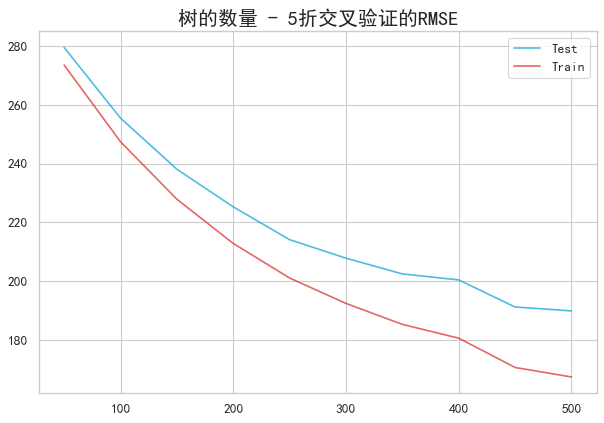

In [42]:
plt.figure(figsize=(9,6),dpi=80)
plt.plot(range(50,550,50),cv_test,color="#01a2d9",alpha=0.7,label="Test")
plt.plot(range(50,550,50),cv_train,color="#dc2624",alpha=0.7,label="Train")
plt.legend()
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("树的数量 - 5折交叉验证的RMSE",fontsize=18)
plt.show()

可以发现，随着num_boost_round的上升，模型开始逐渐出现了一些过拟合的症状。我们可以通过先调整学习率来试图改善过拟合的情况：

In [36]:
cv_train = []
cv_test = []
for eta in np.linspace(0.1,0.5,10):
    params = {"objective":"reg:squarederror"
              ,"eta":eta
              ,"seed":1412} #随机数种子
    result = xgb.cv(params,data,num_boost_round=100,nfold=5,seed=1412)
    cv_test.append(result.iloc[-1,-2])
    cv_train.append(result.iloc[-1,0])
    print("completed {}".format(eta))

completed 0.1
completed 0.14444444444444446
completed 0.18888888888888888
completed 0.23333333333333334
completed 0.2777777777777778
completed 0.32222222222222224
completed 0.3666666666666667
completed 0.4111111111111111
completed 0.4555555555555556
completed 0.5


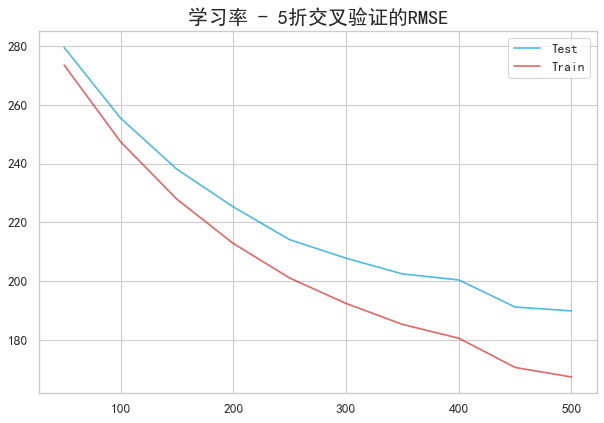

In [37]:
plt.figure(figsize=(9,6),dpi=80)
plt.plot(range(50,550,50),cv_test,color="#01a2d9",alpha=0.7,label="Test")
plt.plot(range(50,550,50),cv_train,color="#dc2624",alpha=0.7,label="Train")
plt.legend()
sns.set(style="whitegrid",font="simhei", font_scale=1.1)
plt.title("学习率 - 5折交叉验证的RMSE",fontsize=18)
plt.show()

- **verbosity**

由于xgboost的训练流程一般较长，因此xgboost在早期就提供了自动监控训练流程的参数。在最早的版本中该参数为silent，后来经过更新变成了今天的verbosity。然而，经过改进之后的verbosity更倾向于帮助我们打印建树相关的信息，而不像原来的silent一样帮助我们展示训练过程中的模型评估信息，因此verbosity现在不那么实用了。

我们可以在verbosity中设置数字[0,1,2,3]，参数默认值为1。

- 0：不打印任何内容
- 1：表示如果有警告，请打印警告
- 2：请打印建树的全部信息
- 3：我正在debug，请帮我打印更多的信息。

我们来看看具体的打印内容：

In [38]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":1 #如果有警告就打印警告，没有警惕则不打印任何内容
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

In [39]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":2 #打印进度
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nod

In [40]:
params = {"objective":"reg:squarederror"
         ,"eta":0.3
         ,"verbosity":3
         ,"seed":1412} #随机数种子
reg = xgb.train(params,data,num_boost_round=10)

[16:47:57] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/gbm/gbtree.cc:155: Using tree method: 2
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:47:57] INFO: 

- **missing**与**num_parallel_tree**

xgboost作为独立于sklearn的机器学习算法库，一直有着两个美誉：

> 1. xgboost可以自动处理缺失值，无需进行填补
> 2. xgboost可以并行建树，因此计算速度很快

这两个美誉分别指向我们的参数missing与num_parallel_tree，但这两个参数的实际应用方式与大家的想象有些不同。先来说简单的参数num_parallel_tree。在num_parallel_tree当中，我们可以输入一个数字，表示允许并行建立的树的数量。当我们不输入任何数字的时候，xgboost库会按照算力进行最大程度的并行。**然而，这种并行功能对论文中描述的xgboost无效，只能被用于使用xgboost库建立随机森林的时候**。随机森林作为bagging算法，天生就可以并行建立树，因此能够并行建树的并不是xgboost，而是xgboost库下的随机森林。

当然，xgboost算法本身也的确实现了速度的提升。虽然根据boosting的原理，树必须是一棵一棵建立的，**但对不同特征的分枝却是可以并行的**。xgboost在原理上实现并行分枝，因此建立每一棵树的速度都比其他集成算法更快。不过，这种并行是xgboost默认的，没有任何的参数可以帮助我们控制这种行为。

接下来来看参数missing，虽然xgboost处理缺失值的能力被传得神乎其神，但实际上，**只要代码允许，任意树模型都可以忍受特征有缺失的数据**。虽然这有些反常识，但树模型的预测结果与特征值本身关系并不大，因为所有叶子上的输出都是依赖于标签进行推导的，特征["A","A","A","B","B"]和特征[1,1,1,2,2]在决策树看来是完全一样的内容。这也是决策树对数据预处理的要求如此之低的关键原因。

来看一个基本的以MSE为criterion进行分枝的例子：

In [47]:
#假设现在对一个特征进行分枝，数据中总共有5个样本
#y_true是5个样本的真实标签
#y_parent是现在的父节点上输出的预测标签，分枝一定是从一个父节点分成两个子节点，因此父节点上的输出一定要存在
#假设父节点就是决策树的根节点
y_true = np.array([[0],[5],[30],[10],[10]])
y_parent = np.array([[11],[11],[11],[11],[11]])

**<center>平方误差的不纯度下降量</center>**
<center>$\frac{\sum_p{(r_i - \hat{y_i})^2}}{w_l + w_r} - (\frac{w_l}{w_l+w_r} * \sum_l{(r_i - \hat{y_i})^2} + \frac{w_r}{w_l+w_r} * \sum_r{(r_i - \hat{y_i})^2})$<br></center><br>


In [48]:
SamplesInParent = 5
for i in range(1,SamplesInParent):
    #打印分枝的可能性
    print("left:{},right:{}".format(i,SamplesInParent-i))
    
    #计算左右叶子节点上的样本量，也就是不纯度下降量公式中的权重
    w_left = i
    w_right = SamplesInParent-i
    
    #父节点上的总MSE
    parentMSE = ((y_true - y_parent)**2).sum()
    
    #计算左右叶子节点上的输出：对回归树来说，就是当前叶子节点上所有样本的真实标签的均值
    y_left = y_true[:i].mean()
    y_right = y_true[i:].mean()
    
    #计算左右叶子节点上的MSE
    leftsum = ((y_true[:i] - y_left)**2).sum()
    rightsum = ((y_true[i:] - y_right)**2).sum()
    
    #加权求和左右叶子节点上的MSE
    childMSE = leftsum*w_left/SamplesInParent + rightsum*w_right/SamplesInParent
    
    print("\t improvement in MSE:{:.3f}".format(parentMSE - childMSE))

left:1,right:4
	 improvement in MSE:225.000
left:2,right:3
	 improvement in MSE:355.000
left:3,right:2
	 improvement in MSE:210.000
left:4,right:1
	 improvement in MSE:105.000


依据MSE下降的结果，父节点子节点MSE差异最大的分枝是左2右3。你发现了，**这个分枝过程当中，完全没有用到任何的特征值**。所以处理缺失值是决策树天生的能力，只不过在sklearn当中，数据可靠性检验的时候不允许有缺失，因此任何算法都无法处理缺失值。在xgboost当中就没有这么严格的可靠性检验，即便数据的特征缺失，还是可以根据标签继续进行分枝计算的。对于xgboost具体是如何处理缺失值的，原作者团队都有一些争议。在xgboost官网上，明确说到有缺失的样本会被删除(removed)，但陈天齐和其他团队成员曾在社交网络上评论说，xgboost不会删除带有缺失值的样本，而会直接根据训练中标签的分枝结果，将带有缺失的样本分到相应的叶子节点上。

根据官网的说明，参数missing可以控制一部分缺失值的处理，**在missing当中我们可以输入任何字符串或数字，xgboost会将数据中任意特征量等于missing参数值的样本删除**。这是说，当我们让missing=1时，数据中任意特征值为1的样本都会被删除，所以missing这个参数的默认值是np.nan。

XGBoost其实是一个非常复杂的算法，为了能够在直播中快速实现参数的调用，我们对于参数本身和许多原理都讲解得很浅显。在《2021机器学习实战》正课当中，我们将详细地剖析XGBoost的各项原理与参数具体应用方法。

****

## 二、LGBM的应用

LGBM是Light Gradient Boosting Machine的缩写，译作轻量梯度提升机器，是最初由Microsoft开发的用于机器学习的免费开源分布式梯度提升框架。和XGBoost一样，LGBM也是在GBDT的基础上改进得来，同时它还借鉴了一些xgboost的思想、集成了一些xgboost的建树和数据处理流程。

|年份|算法/理论|成就/改进|
|----|----|-----|
|2000|GBDT<br>在ADB基础上改进|更新损失函数$L(x,y)$，在数学流程上推广到任意可微函数<br>放弃调整数据分布、放弃弱分类器权重<br>自适应地调整**后续弱评估器拟合的目标**|
|2014|XGBoost<br>在GBDT基础上改进|更新损失函数$L(x,y)$，在损失函数中加入正则项<br>改进弱评估器$f(x)$生长规则，自适应地**调整后续弱评估器的结构**<br>改进拟合中的数学过程，提升拟合精度<br>首次在工程上实现了树分枝的并行，提升运算速度<br>支持GPU加速|
|2016|LGBM<br>在GBDT基础上改进<br>受XGBoost启发|改进弱评估器$f(x)$生长规则，自适应地**调整后续弱评估器的结构**<br>设计了适合于GBDT的数据分布调整方式GOSS，自适应地**调整数据分布**<br>设计了加速弱分类器分枝的计算方式EFB，在工程上大幅度降低了运算时间与内存消耗<br>支持GPU加速|

和xgboost一样，作为独立于sklearn算法库的算法框架，lgbm需要单独进行安装。lgbm的官方页面提供了异常复杂的安装方式（https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#windows）

我们可以使用pip进行安装。除非你pip安装出现问题，否则无需参考官方文档。在pip安装lightgbm之前，确认你的pip版本足够，同时确定你已经安装了wheel包来支持你的lgbm。

In [49]:
!pip install wheel

In [50]:
!pip install lightgbm

In [52]:
import lightgbm as lgb

In [ ]:
#实例化，fit，score/predict
#定义参数，train，predict

lgbm的参数设置方式、训练方式与xgboost类似，都是通过先定义参数、再直接调用函数的方式进行训练，同时参数也是直接通过字典形式进行设置。不过，lgm在超参数数量上比xgboost更加夸张、整体库的灵活性也更强。来看这长长的参数列表：https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters

In [113]:
data = pd.read_csv(r"I:\公开课sample_data2.csv",index_col=0)

In [114]:
data.head()

下单时间  商品一级类别  商品所属渠道     商品ID      品牌  商品销售数量  订单渠道  支付方式   下单用户ID     城市  \
0  14.0     5.0     1.0  15907.0   227.0    41.0   1.0   0.0  24870.0    5.0   
1  14.0    11.0     1.0  15431.0  1551.0    40.0   1.0   0.0  50713.0  207.0   
2  10.0     2.0     1.0  18402.0  2049.0    40.0   1.0   0.0  46259.0  133.0   
3  23.0     5.0     1.0  19080.0   377.0    40.0   1.0   0.0  62154.0  101.0   
4  16.0     3.0     1.0  18580.0   748.0    40.0   1.0   0.0  56469.0  223.0   

   异常    订单金额  
0   1  3009.0  
1   1  2970.0  
2   1   621.0  
3   0  1499.0  
4   0  2799.0

In [65]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [115]:
traindata = lgb.Dataset(X,y) #lgbm, xgboost, pytorch, tf

In [118]:
param = {"seed":1412} #只设计一个参数seed，控制随机性
reg = lgb.train(param,traindata) #自动打印信息，同时默认的树的数量是100

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 131282, number of used features: 11
[LightGBM] [Info] Start training from score 784.113062


这段警告信息与lgbm中独有的分枝方式相关。在普通决策树、Adaboost、GBDT当中，我们是基于不纯度指标的下降量进行分枝，在xgboost当中我们是基于结构分数相关的技术进行分枝，在lgbm当中，我们使用特征或样本的直方图相关的计算作为指标进行分枝，并且**必须在两个方向中二选一**。

![](http://pbarmby.github.io/stuff/python-operations-across-axes.svg)

当我们不在参数设置中进行选择时，算法会分别对特征以及样本方向进行测试、并自动帮我们选择**运行更快**的分枝方式，而这种自动测试需要消耗一定的算力和内存。因此当我们不明确直方图的计算方向时，就会出现警告。我们可以通过在参数中明确行方向或列方向的计算，来让警告消失。

但需要注意的是，行方向的直方图运算一般会比列方向更消耗内存（对于一个样本而言，特征可能有众多不同的取值，对于一个特征而言，不同样本的取值却一定在某个范围之内），因此当内存不足时，我们最好选择列方向进行计算。

In [122]:
param = {"seed":1412, "force_col_wise":True} #也可设置"force_row_wise":True
reg = lgb.train(param,traindata,num_boost_round=10)

[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 131282, number of used features: 11
[LightGBM] [Info] Start training from score 784.113062


In [123]:
y_pred = reg.predict(X) #注意，lgbm的预测方法predict不接受lgbm自己的Dataset类输出的数据，这里需要输入原始数据

In [124]:
#对回归类算法，xgboost的默认评估指标是RMSE
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False) #RMSE

443.2225735673391

In [82]:
#使用交叉验证的方式进行训练

In [130]:
param = {"seed":1412, "metric":"rmse", "force_col_wise":True} #树的生长与树的分枝
result = lgb.cv(param, traindata, nfold=5,num_boost_round=10, seed=1412, stratified=False) #交叉验证时抽样数据

[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 105024, number of used features: 11
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 105024, number of used features: 11
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 105024, number of used features: 11
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 105024, number of used features: 11
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 105024, number of used features: 11
[LightGBM] [Info] Start training from score 782.951640
[LightGBM] [Info] Start training from score 784.545123
[LightGBM] [Info] Start training from score 783.902346
[LightGBM] [Info] Start training from score 784.656650
[LightGBM] [Info] Start training from score 784.544523


在lgb.cv当中默认使用stratified方式进行交叉验证，对回归算法而言无意义。stratified是针对分类算法在kfold基础上进行的调整。在分类数据当中，但每个类别的样本不均匀时，stratified可以保证每份交叉验证数据中，标签的类别分布都与全数据一致。对于回归算法，stratified=True则会报警告，因为回归类算法没有标签类别可以进行分割。

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_003.png)

In [126]:
result #返回得结果是一个字典

{'rmse-mean': [656.7002983721293,
  618.1214417392636,
  585.5066804103318,
  556.7414956670689,
  531.7723985179116,
  509.95819119861756,
  490.597002357197,
  473.5412509284878,
  458.0448343899362,
  445.1964224364686],
 'rmse-stdv': [1.359150872905255,
  1.0423133140726735,
  0.6404904145974113,
  0.6992338424107385,
  1.192271437346355,
  0.9834655846047587,
  1.3610985734728687,
  1.3133066014896402,
  1.8650607672662423,
  1.3486957828691446]}

In [127]:
result = pd.DataFrame(result) #只返回测试集上的结果

In [128]:
result #RMSE - 根均方误差，STDV - 标准差，#建立10棵树的过程中，每次迭代完毕之后的5次交叉验证的平均RMSE和stdv

rmse-mean  rmse-stdv
0  656.700298   1.359151
1  618.121442   1.042313
2  585.506680   0.640490
3  556.741496   0.699234
4  531.772399   1.192271
5  509.958191   0.983466
6  490.597002   1.361099
7  473.541251   1.313307
8  458.044834   1.865061
9  445.196422   1.348696

100棵树上的结果均方误差是278.377，比xgboost高了许多。但从数据的运行速度来看，lgbm是目前为止我们所使用的所有集成算法当中最快的。

与xgboost相似，lgbm也提供了基于sklearn的API运行方式，分别有以下四个：

In [103]:
from lightgbm import LGBMModel, LGBMClassifier, LGBMRegressor, LGBMRanker

我们以LGBMRegressor为例查看一下模型的参数：

*class* `lightgbm.LGBMRegressor`(boosting_type, num_leaves, max_depth, learning_rate, n_estimators, subsample_for_bin, objective, class_weight, min_split_gain, min_child_weight, min_child_samples, subsample, subsample_freq, colsample_bytree, reg_alpha, reg_lambda, random_state, n_jobs, silent, importance_type, **kwargs)

其中的大部分参数看起来都非常熟悉，例如n_estimators, learning_rate, objective, subsample。当然，与XGBoost相同，lgbm当中有许多功能只有在原生代码中才能够实现。之后我们就在原生代码上详细地讲解我们的参数。

In [105]:
reg = LGBMRegressor(n_estimators=100,random_state=1412)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [108]:
result = CSV(reg,X,y,cv=cv,scoring="neg_mean_squared_error")

In [111]:
(abs(result)**0.5).mean()

278.1041099194505

In [112]:
(abs(result)**0.5).var()

9.546768918499128